<a href="https://colab.research.google.com/github/sinilga/DataAnalitics/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project-3.  Анализ воронки

## Введение

### Объект исследования
мобильная игра Quiz Freeze - сборник вопросов в различных форматах и темах, на которые игрокам нужно давать ответы.
### Цель
исследовать поведение пользователей в обновлённом приложении

### Проверяемые гипотезы
1. Существует разница в поведении групп, которые проходят и не проходят обучение. Обучение влияет на скорость прохождения других этапов игры.
2. Повторное прохождение обучения положительно влияет на оплату.
3. Пользователи, выбравшие сложность вопросов до обучения, возвращаются к этапу обучения позже.

### Задачи

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Проверить, насколько прозрачен процесс взаимодействия с игрой.

## 1. Подготовка данных

### 1.1. Загрузка данных

In [1]:
# Подключаем Google-диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Загружаем данные

import pandas as pd
pd.set_option('display.precision',2)

path = '/content/drive/MyDrive/Colab Notebooks/Project-3/'

events_df = pd.read_csv(path + 'events.csv', sep=',')
purchase_df = pd.read_csv(path + 'purchase.csv', sep = ',')

print(f'events_df   : {events_df.shape}')
print(f'purchase_df : {purchase_df.shape}')

events_df   : (252334, 6)
purchase_df : (5956, 4)


### 1.2. Фильтрация по пользователям, зарегистрировавшимся в 2018 году

In [3]:
# users_2018 - пользователи, зарегистрировавшиеся в 2018 году
mask_registration = events_df['event_type']=='registration'
mask_2018 = events_df['start_time'].apply(lambda x: x[:4] =='2018')
users_2018 = events_df[mask_registration & mask_2018]['user_id'].unique()

# фильтруем события по users_2018
events_df = events_df[events_df['user_id'].isin(users_2018)]
registration_df = events_df[events_df['event_type']=='registration']
registration_df = registration_df[registration_df['user_id'].isin(users_2018)]
purchase_df = purchase_df[purchase_df['user_id'].isin(users_2018)]

In [4]:
# Контроль
print(f"Users in dataset       : {events_df['user_id'].nunique()}")
print(f"Users with registration: {registration_df['user_id'].nunique()}")
print(f"Users with purchase    : {purchase_df['user_id'].nunique()}")
print("")

print(f"Registration per user  : {registration_df['user_id'].value_counts().mean()}")
print(f"Purchase per user      : {purchase_df['user_id'].value_counts().mean()}")



Users in dataset       : 19926
Users with registration: 19926
Users with purchase    : 1600

Registration per user  : 1.0
Purchase per user      : 1.0


### 1.3. Объединение оплаты с другими событиями

In [5]:
df1 = events_df.copy()[['user_id','event_type','start_time','tutorial_id']]
df1.rename(columns={'event_type':'type','start_time':'time','tutorial_id':'info'}, inplace=True)

df2 = purchase_df.rename(columns={'event_datetime':'time','amount':'info'})
df2['type'] = 'purchase'
df2 = df2[['user_id','type','time','info']]

df = pd.concat([df1, df2], ignore_index=True)
df['time'].astype('datetime64')
display(df.sort_values(by=['user_id','time']).head())


,user_id,type,time,info
0,27832,registration,2018-01-01T03:48:40,NaN
1,27833,registration,2018-01-01T04:07:25,NaN
12,27833,tutorial_start,2018-01-01T17:47:40,31508.0
13,27833,tutorial_finish,2018-01-01T17:50:08,31508.0
2,27834,registration,2018-01-01T08:35:10,NaN


### 1.4. Подсчет числа событий для пользователей

In [6]:
# число событий каждого типа у пользователей
event_counts = df.pivot_table(index = 'user_id', columns = 'type', values='time', aggfunc = len, fill_value=0)
event_counts.reset_index(inplace=True)
event_counts.head()

type,user_id,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
0,27832,0,0,0,1,0,0
1,27833,0,0,0,1,1,1
2,27834,0,0,0,1,1,1
3,27835,1,1,0,1,1,1
4,27836,0,0,0,1,1,2


### 1.5. Общая характеристка поведения пользователей в игре

In [7]:
# количество действий на одного пользователя
event_counts[event_counts.columns[1:]].describe()

type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
count,19926.00,19926.00,19926.00,19926.0,19926.00,19926.00
mean,0.42,0.29,0.08,1.0,0.75,0.91
std,0.49,0.45,0.27,0.0,1.11,1.28
min,0.00,0.00,0.00,1.0,0.00,0.00
25%,0.00,0.00,0.00,1.0,0.00,0.00
50%,0.00,0.00,0.00,1.0,1.00,1.00
75%,1.00,1.00,0.00,1.0,1.00,1.00
max,1.00,1.00,1.00,1.0,9.00,9.00


Основные действия, составляющие собствено игровой процесс - выбор уровня сложности, выбор пакета бесплатных и приобретение платных вопросов, пользователи совершают не более одного раза.  

Обучение пользователи проходят до 9 раз, однако большинство делает это также не более одного раза.

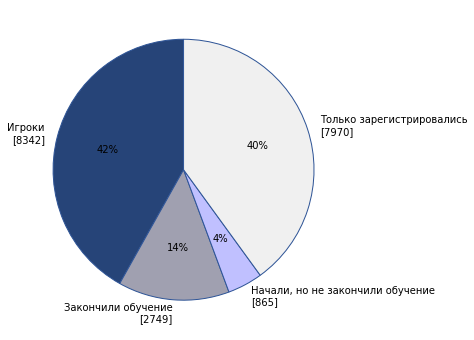

In [8]:
# выполнение основных действий в игре
# игроки - пользователи, выбравшие уровень сложности

not_gamer = event_counts[event_counts.level_choice == 0]            # не стали игроками
reg_only = not_gamer[not_gamer.tutorial_start == 0].shape[0]        # только зарегистрировались
t_done = not_gamer[not_gamer.tutorial_finish > 0].shape[0]          # прошли обучение
t_start = not_gamer[(not_gamer.tutorial_start > 0)             
                    & (not_gamer.tutorial_finish == 0)].shape[0]    # только начали обучение

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=[15,6])

ax.pie(
    [event_counts.shape[0]-not_gamer.shape[0],
     t_done,
     t_start,
     reg_only,
    ], 
    autopct='%1.0f%%', startangle=90, colors=('#264478','#A0A0B0','#C0C0FF','#F0F0F0'),
    labels=(
        'Игроки\n['+str(event_counts.shape[0]-not_gamer.shape[0])+']',
        'Закончили обучение\n['+str(t_done)+']',
        'Начали, но не закончили обучение\n['+str(t_start)+']',
        'Только зарегистрировались\n['+str(reg_only)+']'),
    wedgeprops = {'linewidth': 1, 'edgecolor':'#2F5597'}
) 
plt.show()

Более половины пользователей, зарегистрировавшихся в 2018 году не приступили к игре (не выбрали уровень сложности), в т.ч. 40% не выполнили никаких действий после регистрации.

In [9]:
# количество обучений, которые проходят пользователи до начала игры
game_start = df[df.type=='level_choice'][['user_id','time']]
game_start.rename(columns={'time':'game_start'},inplace=True)
df_s = df.merge(game_start, on='user_id')
df_s = df_s[(df_s.type.str.match('tutorial')) & (df_s.time <= df_s.game_start)]
tmp = df_s.pivot_table(index='user_id', columns='type',values='time',aggfunc='count')
print('Количество обучений до выбора уровня сложности')
display(pd.DataFrame({'start': tmp.tutorial_start.value_counts(sort=False),'finish': tmp.tutorial_finish.value_counts(sort=False)}).fillna("-").transpose())


Количество обучений до выбора уровня сложности


,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
start,7180,734,181,79,41,22,6,1
finish,6784.0,510.0,122.0,56.0,20.0,8.0,1.0,-


Пользователи могут пройти обучение несколько раз еще до того, как начать играть

In [10]:
# Фиксируем моменты совершения пользователями действий всех типов (events_time)
# df - перечень всех событий вместе с оплатой (https://colab.research.google.com/drive/1TZf0BjCYTJ1C8mPH_lVnX1SdpeQgk8GT#scrollTo=ehIXeZtvqSNO&line=11&uniqifier=1)

time_pt = df.pivot_table(index=['user_id'],columns=['type'],values=['time'],aggfunc=min)

events_time = pd.DataFrame( {
                             'registration':time_pt.time.registration,
                             'level_choice':time_pt.time.level_choice,
                             'pack_choice':time_pt.time.pack_choice,
                             'purchase':time_pt.time.purchase } )
events_time = events_time.astype('datetime64[ns]')

events_time.reset_index(inplace=True)

# Добавляем время прохождения этапов
events_time['reg_level'] = (events_time.level_choice - events_time.registration).dt.total_seconds()/3600
events_time['level_pack'] = (events_time.pack_choice - events_time.level_choice).dt.total_seconds()/60
events_time['pack_purchase'] = (events_time.purchase - events_time.pack_choice).dt.total_seconds()/3600
events_time['reg_pack'] = (events_time.pack_choice - events_time.registration).dt.total_seconds()/3600
events_time['reg_purchase'] = (events_time.purchase - events_time.registration).dt.total_seconds()/3600

In [11]:
# Проверка последовательности прохождения этапов игры

# этап <stage_from> существует и предшествует по времени этапу <stage_to>
def print_checker(stage_from, stage_to):
    res = time_pt.time[stage_to].isna() \
        | time_pt.time[stage_from].notna() & time_pt.time[stage_to].notna() \
        & (time_pt.time[stage_to] > time_pt.time[stage_from])
    print(f"{stage_from:14s} -> {stage_to:16s}:{res.all()}")


print_checker('registration','level_choice')
print_checker('level_choice','pack_choice')
print_checker('pack_choice','purchase')
print_checker('registration','tutorial_start')
print_checker('tutorial_start','tutorial_finish')

registration   -> level_choice    :True
level_choice   -> pack_choice     :True
pack_choice    -> purchase        :True
registration   -> tutorial_start  :True
tutorial_start -> tutorial_finish :True


Аномалий в последовательности прохождения этапов игры нет.

## 2. Проверка гипотез

### 2.1. Гипотеза: существует разница в поведении групп, которые проходят и не проходят обучение. Обучение влияет на скорость прохождения других этапов игры

> Отличается ли время прохождения различных этапов у пользователей, которые прошли обучение, и пользователей, не начинавших обучение.
> Насколько обучение сокращает время прохождения этапов игры.


In [12]:
# Группы пользователей

# Прошли обучение полностью
study_done = event_counts[event_counts.tutorial_finish > 0]['user_id']

# Начали, но не закончили
study_start = event_counts[(event_counts.tutorial_start > 0) & (event_counts.tutorial_finish == 0)]['user_id']

# Не начинали обучение
study_none = event_counts[event_counts.tutorial_start == 0]['user_id']

# Проверка
print('Размеры групп')
print('='*25)
print(f'study_done  : {study_done.count():6}')
print(f'study_start : {study_start.count():6}')
print(f'study_none  : {study_none.count():6}')
print('-'*25)
print(f'              {study_done.count() + study_start.count() + study_none.count():6}')

Размеры групп
study_done  :  10250
study_start :   1608
study_none  :   8068
-------------------------
               19926


In [13]:
# добавляем в events_time группы пользователей

def get_user_group(id):
  if id in study_done.values:
    return 'finish'
  elif id in study_start.values:
    return 'start'  
  else:
    return 'none'  
events_time['group'] = events_time.user_id.apply(get_user_group)
display(events_time[::100].head().fillna("-"))

,user_id,registration,level_choice,pack_choice,purchase,reg_level,level_pack,pack_purchase,reg_pack,reg_purchase,group
0,27832,2018-01-01 03:48:40,-,-,-,-,-,-,-,-,none
100,27932,2018-01-05 20:17:02,-,-,-,-,-,-,-,-,start
200,28032,2018-01-08 16:47:15,2018-01-08 23:05:09,2018-01-08 23:08:11,-,6.3,3.03,-,6.35,-,finish
300,28132,2018-01-10 15:35:47,2018-01-10 18:31:40,-,-,2.93,-,-,-,-,finish
400,28232,2018-01-11 22:40:33,2018-01-12 05:34:01,2018-01-12 05:38:39,-,6.89,4.63,-,6.97,-,finish


In [14]:
line_color = '#404040'
mpl.rcParams['boxplot.vertical'] = False
mpl.rcParams['boxplot.showmeans'] = True
mpl.rcParams['boxplot.meanline'] = False
mpl.rcParams['boxplot.meanprops.markerfacecolor'] = 'navy'
mpl.rcParams['boxplot.meanprops.markeredgecolor'] = 'black'
mpl.rcParams['boxplot.medianprops.color'] = 'blue'
mpl.rcParams['boxplot.whiskerprops.color'] = line_color
mpl.rcParams['boxplot.flierprops.markeredgecolor'] = line_color
mpl.rcParams['boxplot.capprops.color'] = line_color

# Вспомогательные функции:

# формируем список series для построения barplot
def prep_data(stage):
  res = [] 
  for group in ['finish','start','none']:
    res.append(events_time[(events_time['group'] == group) & (events_time[stage].notna())][stage])
  return res  


# настройки осей и название диаграммы
def ax_sets(ax, title, measure):
    ax.set(
        axisbelow = True,
        title = title,
        xlabel = measure,
        ylabel = 'Группы пользователей',
    )
    ax.set_title(title, fontdict = {'fontsize': 14, 'fontweight': 'bold'})


# раскраска для barplot
def decor(bp):
    for box, color in zip(bp['boxes'], ['lightgreen','lightblue','pink']):
        box.set_facecolor(color)
        box.set_edgecolor(line_color)


#### Выбор уровня сложности вопросов

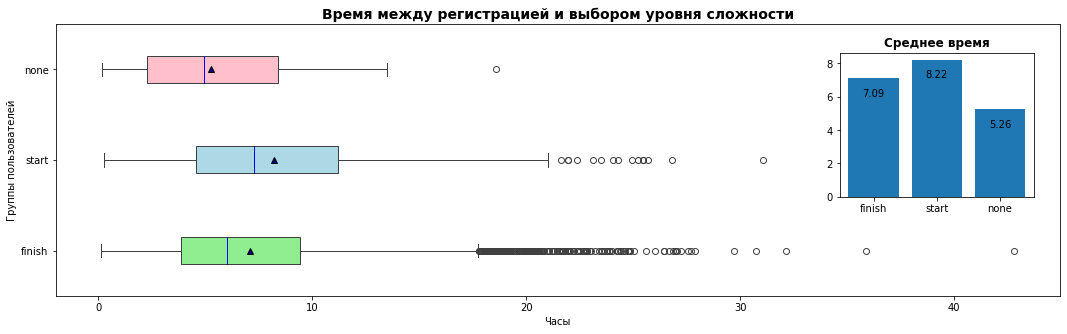

In [15]:
# Регистрация - выбор уровня (в часах)
dx = prep_data('reg_level')
fig, ax = plt.subplots(figsize=(18,5))
reg_lev_bp = ax.boxplot(dx, labels = ['finish','start','none'], 
           patch_artist=True)
ax_sets(ax, "Время между регистрацией и выбором уровня сложности", "Часы")
decor(reg_lev_bp)

ax2 = fig.add_axes([0.73, 0.4, 0.15, 0.4])
means_bar = ax2.bar(['finish','start','none'],list(map(lambda x:x.mean(),dx)))
ax2.bar_label(means_bar, fmt='%0.2f', label_type='edge', padding=-20)
ax2.set_title('Среднее время', fontdict={'fontweight':'bold'})
plt.show()

Среднее время для закончивших обучение составляет около 7 часов. Это на 35% больше, чем для пользователей, не начинавших обучение, но на 18% ниже, чем у тех, кто начал, но не закончил.

#### Выбор пакета бесплатных вопросов

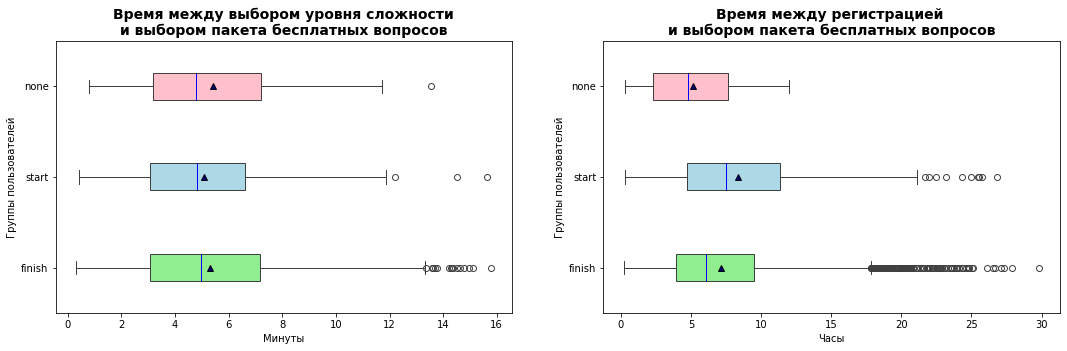

from_level_choice                        from_registration             \
                    mean delta none delta start              mean delta none   
finish              5.30     -1.85%       4.13%              7.18     40.23%   
start               5.09     -5.74%       0.00%              8.38     63.67%   
none                5.40      0.00%       6.09%              5.12      0.00%   

                    
       delta start  
finish     -14.32%  
start        0.00%  
none       -38.90%

In [16]:
# выбор уровня - выбор пакета вопросов (в минутах)
fig, ax = plt.subplots(1,2,figsize=(18,5))

lev_pack_dx = prep_data('level_pack')
lev_pack_bp = ax[0].boxplot(lev_pack_dx, vert=False, labels = ['finish','start','none'],patch_artist=True, showmeans=True)
ax_sets(ax[0], "Время между выбором уровня сложности\nи выбором пакета бесплатных вопросов", "Минуты")
decor(lev_pack_bp)

reg_pack_dx = prep_data('reg_pack')
reg_pack_bp = ax[1].boxplot(reg_pack_dx, vert=False, labels = ['finish','start','none'],patch_artist=True, showmeans=True)
ax_sets(ax[1], "Время между регистрацией \nи выбором пакета бесплатных вопросов", "Часы")
decor(reg_pack_bp)

plt.show()

# таблица
lev_pack_df = pd.DataFrame(
        index=['finish','start','none'],
        columns=pd.MultiIndex.from_tuples(
            [('from_level_choice','mean'),
             ('from_level_choice','delta none'),
             ('from_level_choice','delta start'),
             ('from_registration','mean'),
             ('from_registration','delta none'),
             ('from_registration','delta start'),
            ]
        )
)

lev_pack_df[('from_level_choice','mean')] = list(map(lambda x: round(x.mean(),2),lev_pack_dx))
lev_pack_df[('from_registration','mean')] = list(map(lambda x: round(x.mean(),2),reg_pack_dx))
lev_pack_df[('from_level_choice','delta none')] = lev_pack_df[('from_level_choice','mean')]/lev_pack_df.at['none',('from_level_choice','mean')] - 1
lev_pack_df[('from_level_choice','delta start')] = lev_pack_df[('from_level_choice','mean')]/lev_pack_df.at['start',('from_level_choice','mean')] - 1 
lev_pack_df[('from_registration','delta none')] = lev_pack_df[('from_registration','mean')]/lev_pack_df.at['none',('from_registration','mean')] - 1 
lev_pack_df[('from_registration','delta start')] = lev_pack_df[('from_registration','mean')]/lev_pack_df.at['start',('from_registration','mean')] - 1 
lev_pack_df[('from_level_choice','delta none')] = lev_pack_df[('from_level_choice','delta none')].apply(lambda x:f'{x:.2%}')
lev_pack_df[('from_level_choice','delta start')] = lev_pack_df[('from_level_choice','delta start')].apply(lambda x:f'{x:.2%}')
lev_pack_df[('from_registration','delta none')] = lev_pack_df[('from_registration','delta none')].apply(lambda x:f'{x:.2%}')
lev_pack_df[('from_registration','delta start')] = lev_pack_df[('from_registration','delta start')].apply(lambda x:f'{x:.2%}')

display(lev_pack_df)


#### Покупка платных пакетов вопросов

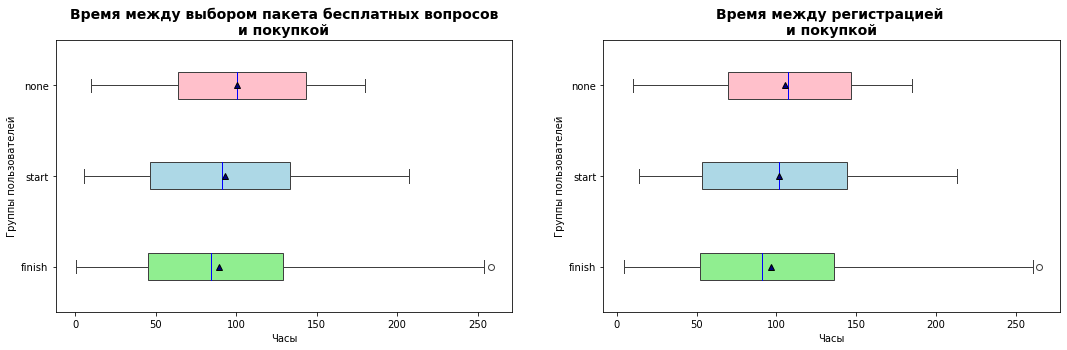

from_pack_choice                        from_registration             \
                   mean delta none delta start              mean delta none   
finish            89.30    -11.44%      -4.24%             96.50     -8.18%   
start             93.25     -7.52%       0.00%            101.55     -3.38%   
none             100.83      0.00%       8.13%            105.10      0.00%   

                    
       delta start  
finish      -4.97%  
start        0.00%  
none         3.50%

In [17]:
# выбор пакета вопросов - покупка (в часах)
fig, ax = plt.subplots(1,2,figsize=(18,5))

pack_purch_dx = prep_data('pack_purchase')
pack_purch_bp = ax[0].boxplot(pack_purch_dx, vert=False, labels = ['finish','start','none'],patch_artist=True, showmeans=True)
ax_sets(ax[0], "Время между выбором пакета бесплатных вопросов\nи покупкой", "Часы")
decor(pack_purch_bp)

reg_purch_dx = prep_data('reg_purchase')
reg_purch_bp = ax[1].boxplot(reg_purch_dx, vert=False, labels = ['finish','start','none'],patch_artist=True, showmeans=True)
ax_sets(ax[1], "Время между регистрацией \nи покупкой", "Часы")
decor(reg_purch_bp)
plt.show()

# таблица
pack_purch_df = pd.DataFrame(
        index=['finish','start','none'],
        columns=pd.MultiIndex.from_tuples(
            [('from_pack_choice','mean'),
             ('from_pack_choice','delta none'),
             ('from_pack_choice','delta start'),
             ('from_registration','mean'),
             ('from_registration','delta none'),
             ('from_registration','delta start'),
            ]
        )
)

pack_purch_df[('from_pack_choice','mean')] = list(map(lambda x: round(x.mean(),2),pack_purch_dx))
pack_purch_df[('from_registration','mean')] = list(map(lambda x: round(x.mean(),2),reg_purch_dx))
pack_purch_df[('from_pack_choice','delta none')] = pack_purch_df[('from_pack_choice','mean')]/pack_purch_df.at['none',('from_pack_choice','mean')] - 1
pack_purch_df[('from_pack_choice','delta start')] = pack_purch_df[('from_pack_choice','mean')]/pack_purch_df.at['start',('from_pack_choice','mean')] - 1 
pack_purch_df[('from_registration','delta none')] = pack_purch_df[('from_registration','mean')]/pack_purch_df.at['none',('from_registration','mean')] - 1 
pack_purch_df[('from_registration','delta start')] = pack_purch_df[('from_registration','mean')]/pack_purch_df.at['start',('from_registration','mean')] - 1 
pack_purch_df[('from_pack_choice','delta none')] = pack_purch_df[('from_pack_choice','delta none')].apply(lambda x:f'{x:.2%}')
pack_purch_df[('from_pack_choice','delta start')] = pack_purch_df[('from_pack_choice','delta start')].apply(lambda x:f'{x:.2%}')
pack_purch_df[('from_registration','delta none')] = pack_purch_df[('from_registration','delta none')].apply(lambda x:f'{x:.2%}')
pack_purch_df[('from_registration','delta start')] = pack_purch_df[('from_registration','delta start')].apply(lambda x:f'{x:.2%}')

display(pack_purch_df)


Пользователи, завершившие обучение, быстрее переходят к покупке.

### 2.2. Гипотеза: повторное прохождение обучения положительно влияет на оплату
> Существует ли зависимость между вероятностью оплаты и количеством обучений, которые начинал или завершал пользователь.

>Успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло

In [18]:
# Обучений 1-9, мед.1, ср. 1,4, 90%-перс - 2
tutorials = event_counts[event_counts['tutorial_start'] > 0]
tutorials[['tutorial_start','tutorial_finish']].describe()

type,tutorial_start,tutorial_finish
count,11858.00,11858.00
mean,1.52,1.26
std,1.35,1.20
min,1.00,0.00
25%,1.00,1.00
50%,1.00,1.00
75%,1.00,1.00
max,9.00,9.00


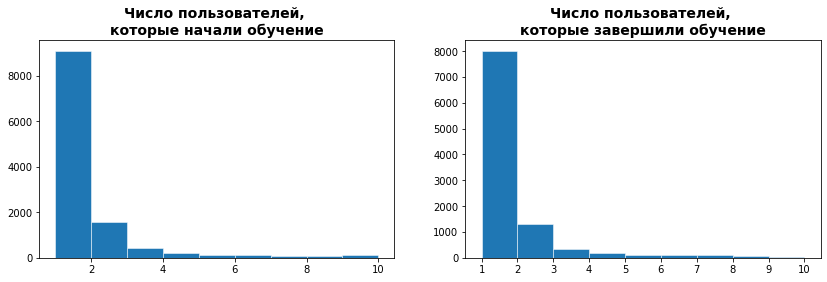

In [19]:
fig, ax = plt.subplots(1,2, figsize = (14,4))

ax[0].hist(tutorials['tutorial_start'], bins = range(1,11), linewidth=0.5, edgecolor="white")
ax[0].set_xticks=(range(1,11))
ax[0].set_title("Число пользователей, \nкоторые начали обучение", fontdict = {'fontsize': 14, 'fontweight': 'bold'})

ax[1].hist(tutorials['tutorial_finish'], bins = range(1,11), linewidth=0.5, edgecolor="white")
ax[1].set_xticks(range(1,11))
ax[1].set_title("Число пользователей, \nкоторые завершили обучение", fontdict = {'fontsize': 14, 'fontweight': 'bold'})

plt.show()

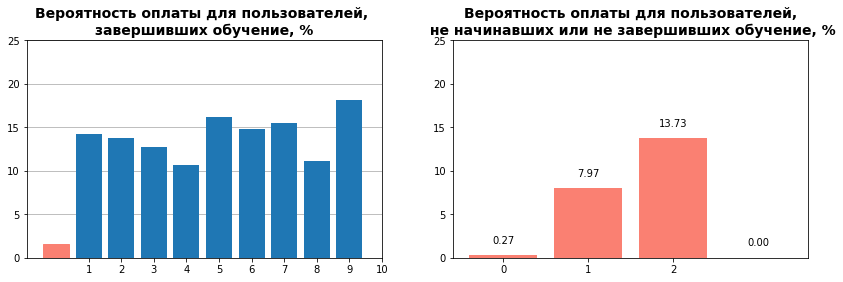


Средняя взвешенная вероятность оплаты для завершивших обучение хотя бы один раз: 14.12%


tutorial_finish,0,1,2,3,4,5,6,7,8,9
count,9676.00,8015.00,1321.00,345.00,178.00,117.00,101.00,97.00,54.00,22.00
rate,1.58,14.26,13.78,12.75,10.67,16.24,14.85,15.46,11.11,18.18




Данные о пользователях не начинавших или не завершивших обучение
Средняя взвешенная вероятность оплаты для начавших обучение хотя бы один раз: 8.15%


tutorial_start,0,1,2,3
count,8068.00,1555.00,51.00,2.0
rate,0.27,7.97,13.73,0.0


In [20]:
finish_pay = event_counts.groupby('tutorial_finish')['purchase'] \
    .agg(
        count = 'count', 
        rate = (lambda x: 100*x.sum()/x.count())
    )

mask = event_counts['user_id'].isin(study_done)
start_pay = event_counts[mask==False].groupby('tutorial_start')['purchase'] \
    .agg(
        count = 'count', 
        rate = (lambda x: 100*x.sum()/x.count())
    )
start_pay.describe()
fig, ax = plt.subplots(1,2, figsize = (14,4))

bp1 = ax[0].bar(finish_pay.index,finish_pay['rate'])
ax[0].set(xticks=range(1,11), axisbelow = True)
ax[0].set_title("Вероятность оплаты для пользователей, \nзавершивших обучение, %", fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax[0].grid(visible=True, axis='y')
ax[0].set_ylim(top=25)
bp1.patches[0].set_color('salmon')

bp2 = ax[1].bar(start_pay.index,start_pay['rate'], color='salmon')
ax[1].set(xticks=range(0,3), axisbelow = True)
ax[1].set_title("Вероятность оплаты для пользователей,\n не начинавших или не завершивших обучение, %", fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax[1].sharey(ax[0])
ax[1].bar_label(bp2, fmt='%0.2f', label_type='edge', padding=10)

plt.show()

print()
print('='*45)
wavg_finish_pay = (finish_pay[1::]['count']*finish_pay[1::]['rate']).sum()/finish_pay[1::]['count'].sum()
print(f'Средняя взвешенная вероятность оплаты для завершивших обучение хотя бы один раз: {wavg_finish_pay :0.2f}%')
display(pd.DataFrame(finish_pay).transpose().round(2))

print('\n')
print('Данные о пользователях не начинавших или не завершивших обучение')
wavg_start_pay = (start_pay[1::]['count']*start_pay[1::]['rate']).sum()/start_pay[1::]['count'].sum()
print(f'Средняя взвешенная вероятность оплаты для начавших обучение хотя бы один раз: {wavg_start_pay:0.2f}%')
display(pd.DataFrame(start_pay).transpose().round(2))


Среди пользователей, завершивших обучение хотя бы один раз,  доля совершивших покупку составляет в среднем 14% , что выше, чем среди пользователей, не начинавших или начавших, но не закончивших обучение (менее 2%).

Среди тех, кто ни разу не завершал обучение, вероятность покупки выше для пользователей, которые хотя бы приступали к нему (8% ).

Количество обучений влияет на вероятность покупки заметно меньше: разборос значений от 11 до 18%.

#### Примечание
Вместе с тем если исключить из числа потенциальных плательщиков пользователей, которое бросили игру сразу после регистрации, то разница между игроками завершившими обучение и не завершавшими его будет не столь впечаляющей: 14% и 9% соответственно.

При этом, игроки вовсе не начинавшие обучение доходят до оплаты в 22% случаев:

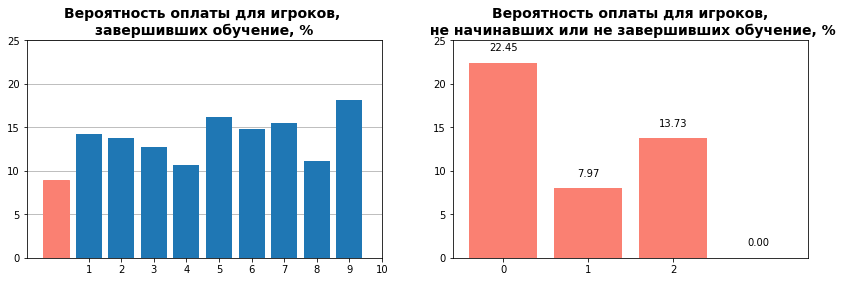


Средняя взвешенная вероятность оплаты для игроков, завершивших обучение хотя бы один раз: 14.12%


tutorial_finish,0,1,2,3,4,5,6,7,8,9
count,1706.00,8015.00,1321.00,345.00,178.00,117.00,101.00,97.00,54.00,22.00
rate,8.97,14.26,13.78,12.75,10.67,16.24,14.85,15.46,11.11,18.18




Данные об игроках не начинавших или не завершивших обучение
Средняя взвешенная вероятность оплаты для начавших обучение хотя бы один раз: 8.15%


tutorial_start,0,1,2,3
count,98.00,1555.00,51.00,2.0
rate,22.45,7.97,13.73,0.0


In [21]:
gamers = event_counts[(event_counts['level_choice'] > 0) | (event_counts['tutorial_start'] > 0)]
gamer_finish_pay = gamers.groupby('tutorial_finish')['purchase'] \
    .agg(
        count = 'count', 
        rate = (lambda x: 100*x.sum()/x.count())
    )

mask = gamers['user_id'].isin(study_done)
gamer_start_pay = gamers[mask==False].groupby('tutorial_start')['purchase'] \
    .agg(
        count = 'count', 
        rate = (lambda x: 100*x.sum()/x.count())
    )
fig, ax = plt.subplots(1,2, figsize = (14,4))


bp1 = ax[0].bar(gamer_finish_pay.index,gamer_finish_pay['rate'])
ax[0].set(xticks=range(1,11), axisbelow = True)
ax[0].set_title("Вероятность оплаты для игроков, \nзавершивших обучение, %", fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax[0].grid(visible=True, axis='y')
ax[0].set_ylim(top=25)
bp1.patches[0].set_color('salmon')

bp2 = ax[1].bar(gamer_start_pay.index,gamer_start_pay['rate'], color='salmon')
ax[1].set(xticks=range(0,3), axisbelow = True)
ax[1].set_title("Вероятность оплаты для игроков,\n не начинавших или не завершивших обучение, %", fontdict = {'fontsize': 14, 'fontweight': 'bold'})
ax[1].sharey(ax[0])
ax[1].bar_label(bp2, fmt='%0.2f', label_type='edge', padding=10)

plt.show()

print()
print('='*45)
gamer_wavg_finish_pay = (gamer_finish_pay[1::]['count']*gamer_finish_pay[1::]['rate']).sum()/gamer_finish_pay[1::]['count'].sum()
print(f'Средняя взвешенная вероятность оплаты для игроков, завершивших обучение хотя бы один раз: {gamer_wavg_finish_pay :0.2f}%')
display(pd.DataFrame(gamer_finish_pay).transpose().round(2))

print('\n')
print('Данные об игроках не начинавших или не завершивших обучение')
gamer_wavg_start_pay = (gamer_start_pay[1::]['count']*gamer_start_pay[1::]['rate']).sum()/gamer_start_pay[1::]['count'].sum()
print(f'Средняя взвешенная вероятность оплаты для начавших обучение хотя бы один раз: {gamer_wavg_start_pay:0.2f}%')
display(pd.DataFrame(gamer_start_pay).transpose().round(2))

### 2.3. Гипотеза: пользователи, выбравшие сложность вопросов до обучения, возвращаются к этапу обучения позже.

> Как часто пользователи начинают обучение после того, как выбрали уровень сложности тренировок.

> Насколько прозрачен процесс взаимодействия с игрой

In [22]:
# определяем количество обучений после выбора уровня сложности

lt_df = df[(df.type=='level_choice')|(df.type=='tutorial_start')].pivot_table(
    index='user_id',
    columns='type',
    values='time',
    aggfunc=['min','max']
)

fst_tutorials = lt_df[lt_df['min'].level_choice < lt_df['min'].tutorial_start].shape[0]
rep_tutorials = lt_df[lt_df['min'].level_choice < lt_df['max'].tutorial_start].shape[0]
lev_users = lt_df[lt_df['min'].level_choice.notna()].shape[0]

print(f'Дошли до выбора уровня: {lev_users}')
print(f'Начали первое обучение после выбора уровня: {fst_tutorials} ({fst_tutorials/lev_users:0.2%})')
print(f'Начали повторное обучение после выбора уровня: {rep_tutorials} ({rep_tutorials/lev_users:0.2%})')

Дошли до выбора уровня: 8342
Начали первое обучение после выбора уровня: 0 (0.00%)
Начали повторное обучение после выбора уровня: 1386 (16.61%)


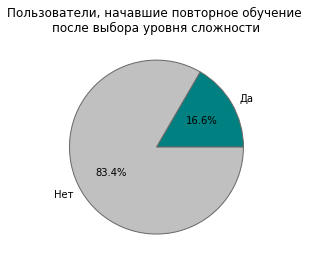

In [23]:
fig, ax = plt.subplots()
ax.pie([rep_tutorials,lev_users-rep_tutorials], 
    labels=['Да','Нет'], 
    autopct='%1.1f%%',
    colors=['teal', 'silver'],
    wedgeprops = {'linewidth': 1, 'edgecolor':'dimgray'}
)
ax.set_title("Пользователи, начавшие повторное обучение \nпосле выбора уровня сложности")
plt.show()

## Выводы

1. Гипотеза 1 "***Существует разница в поведении групп, которые проходят и не проходят обучение. Обучение влияет на скорость прохождения других этапов игры.***" подтвердилась.

Игроки, завершившие обучение, в среднем проходят путь от регистрации до оплаты на 8% быстрее, чем игроки, не начинавшие обучение. Данное сокращение времении проявляется лишь на последнем этапе, тогда как на этапах выбора уровня сложности и пакета бесплатных вопросов прошедшие обучение игроки, наоброт,  тратят больше времени.


2. Гипотеза 2 "***Повторное прохождение обучения положительно влияет на оплату***" не подтвердилась. 

Разница в вероятности совершения оплаты между игроками, прошедшими обучение единожды и многократно, ниже, чем разница с игроками, не завершившими его ни разу. Вместе с тем в последней группе игроки, не начинавшие обучение, совершают оплату с большей верятностью, чем те, кто начал его и бросил.

Можно полагать, что общая заинтересованность пользователя игройй влияет на оплату сильнее, чем обучение.

3. Гипотеза 3 "***Пользователи, выбравшие сложность вопросов до обучения, возвращаются к этапу обучения позже***" не подтвердилась.

Не зафиксировано ни одного случая, чтобы пользователь выбравший уровень сложности минуя обучение, вернулся к данному этапу позже.

Пользователи, выбравшие сложность вопросов до обучения, возвращаются к этапу обучения позже.

Для всех игроков, проходивших обучение после выбора уровня сложности, оно было повторным.

Можно предполагать, что процесс взаимодействия с игрой недостаточно понятен пользователям, вследствие чего они вынуждены обучаться многократно, также, возможно, игроки, пропустившие этап обучения, испытывают затруднения в возвращении к нему с более поздних этапов игры.

Рекомендуется пересмотреть интерфейс игры и сценарий обучения с целью повышения ее привлекательности и доступности.